# Time series of spring phytoplankton bloom and model forcing at station S3 from Feb 15th - June 15th 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os

%matplotlib inline

In [2]:
start=dt.datetime(2018,2,15)
end=dt.datetime(2018,6,15)
year=str(start.year)
modver='201812'

### Location of station S3

Text(0, 0.5, 'Latitude')

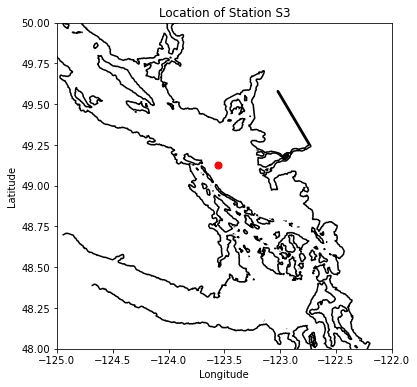

In [3]:
loc='S3'

# lat and lon informatin for place:
lon,lat=places.PLACES['S3']['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES['S3']['NEMO grid ji']
# GEM2.5 grid ji is atm forcing grid for ops files
jw,iw=places.PLACES['S3']['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords ='map', isobath=.1)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station S3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### load data

In [4]:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
#savedir='/data/eolson/results/MEOPAR'
fname=f'springTimeSeries_{year}_{loc}_{modver}.pkl'
savepath=os.path.join(savedir,fname)
recalc=False

In [5]:
if recalc==True or not os.path.isfile(savepath):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
    # flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file
    # a list of the files we want between start and end date
    print(flist)
    fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        bio_time=np.array(bio.time_centered[:])
        sno3=np.array(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
        sdiat=np.array(bio.diatoms.isel(deptht=ik,y=ij,x=ii))
        sflag=np.array(bio.flagellates.isel(deptht=ik,y=ij,x=ii))
        scili=np.array(bio.ciliates.isel(deptht=ik,y=ij,x=ii))
        with xr.open_mfdataset(fliste3t['paths']) as carp:
            intdiat=np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)) # depth integrated diatom
            intphyto=np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                            +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1))
            spar=np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii))
    fracdiat=intdiat/intphyto # depth integrated fraction of diatoms

    sphyto=sdiat+sflag+scili
    percdiat=sdiat/sphyto # percent diatoms

    opsdir='/results/forcing/atmospheric/GEM2.5/operational'

    flist2=et.index_model_files(start,end,opsdir,nam_fmt='ops',flen=1,ftype='None',tres=24)
    with xr.open_mfdataset(flist2['paths']) as winds:
        u_wind=np.array(winds.u_wind.isel(y=jw,x=iw))
        v_wind=np.array(winds.v_wind.isel(y=jw,x=iw))
        twind=np.array(winds.time_counter)
        solar=np.array(winds.solar.isel(y=jw,x=iw))
    # wind speed:
    wspeed=np.sqrt(u_wind**2 + v_wind**2)
    # wind direction in degrees from east
    d = np.arctan2(v_wind, u_wind)
    winddirec=np.rad2deg(d + (d < 0)*2*np.pi)

    # reading Fraser river flow files
    dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Dec-2-2020_10_31_05PM.csv',
                      skiprows=1)
    # the original file contains both flow and water level information in the same field (Value)
    # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
    # flow units are m3/s
    # DD is YD, year day (ie. 1 is jan 1)
    dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

    # rename 'Value' column to 'Flow' now that we have removed all the water level rows
    dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
        # inplace=True does this function on the orginal dataframe

    # no time information so use dt.date
    dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
    # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
    dfFra.head(2)

    # select portion of dataframe in desired date range
    dfFra2=dfFra.loc[(dfFra.Date>=start.date())&(dfFra.Date<=end.date())]
    riv_time=dfFra2['Date'].values
    rivFlow=dfFra2['Flow'].values
    # could also write dfFra['Date'], sometimes this is required
    # newstart is a datetime object, so we convert it to just a date with .date
    pickle.dump((bio_time,sno3,sdiat,sflag,scili,intdiat,intphyto,spar,fracdiat,sphyto,percdiat,
            u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow),open(savepath,'wb'))
else:
    bio_time,sno3,sdiat,sflag,scili,intdiat,intphyto,spar,fracdiat,sphyto,percdiat,\
            u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow=pickle.load(open(savepath,'rb'))

                                                 paths        t_0        t_n
0    /results/SalishSea/nowcast-green.201812/15feb1... 2018-02-15 2018-02-16
1    /results/SalishSea/nowcast-green.201812/16feb1... 2018-02-16 2018-02-17
2    /results/SalishSea/nowcast-green.201812/17feb1... 2018-02-17 2018-02-18
3    /results/SalishSea/nowcast-green.201812/18feb1... 2018-02-18 2018-02-19
4    /results/SalishSea/nowcast-green.201812/19feb1... 2018-02-19 2018-02-20
..                                                 ...        ...        ...
116  /results/SalishSea/nowcast-green.201812/11jun1... 2018-06-11 2018-06-12
117  /results/SalishSea/nowcast-green.201812/12jun1... 2018-06-12 2018-06-13
118  /results/SalishSea/nowcast-green.201812/13jun1... 2018-06-13 2018-06-14
119  /results/SalishSea/nowcast-green.201812/14jun1... 2018-06-14 2018-06-15
120  /results/SalishSea/nowcast-green.201812/15jun1... 2018-06-15 2018-06-16

[121 rows x 3 columns]


### Total surface phytoplankton and nitrate:

Text(0.5, 1.0, 'Surface Phytoplankton and Nitrate at Station S3')

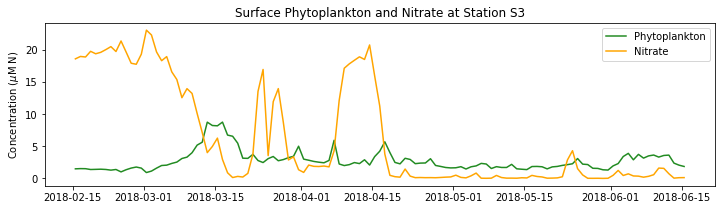

In [6]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
p1=ax.plot(bio_time,sphyto,
           '-',color='forestgreen',label='Phytoplankton')
p2=ax.plot(bio_time,sno3,
           '-',color='orange',label='Nitrate')
ax.legend(handles=[p1[0],p2[0]],loc=1)
ax.set_ylabel('Concentration ($\mu$M N)')
ax.set_title('Surface Phytoplankton and Nitrate at Station S3')

### Fraction of surface phytoplankton that is diatoms

(0.0, 1.0)

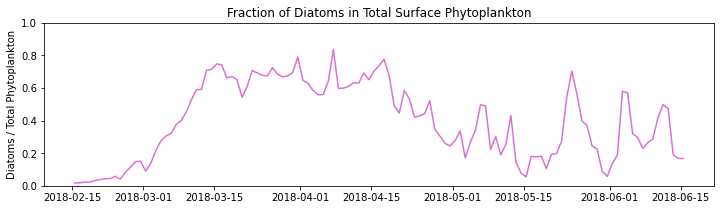

In [7]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(bio_time,percdiat, '-',color='orchid')
ax.set_ylabel('Diatoms / Total Phytoplankton')
ax.set_title('Fraction of Diatoms in Total Surface Phytoplankton')
ax.set_ylim(0,1)

### Depth integrated phytoplankton:

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 17.4 ms


Text(0.5, 1.0, 'Depth Integrated Phytoplankton Concentration')

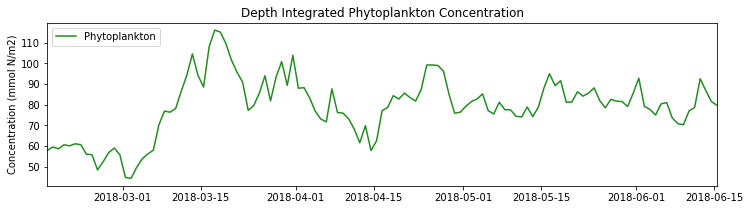

In [8]:
%%time
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(bio_time,intphyto,'-',color='forestgreen',label='Phytoplankton')
ax.legend(loc=2);
ax.set_ylabel('Concentration (mmol N/m2)')
ax.set_xlim(bio_time[0],bio_time[-1])
ax.set_title('Depth Integrated Phytoplankton Concentration')

### Fraction of depth integrated phytoplankton that is diatoms

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16.6 ms


(0.0, 1.0)

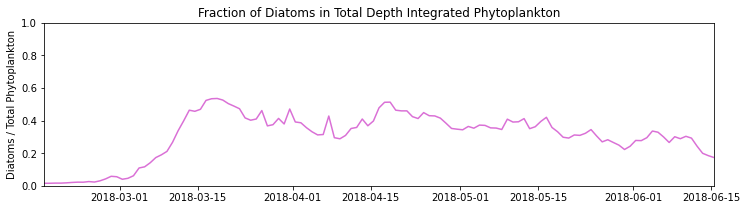

In [9]:
%%time
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(bio_time,fracdiat,'-',color='orchid')
ax.set_ylabel('Diatoms / Total Phytoplankton')
ax.set_xlim(bio_time[0],bio_time[-1])
ax.set_title('Fraction of Diatoms in Total Depth Integrated Phytoplankton')
ax.set_ylim(0,1)

### Fraser River Flow

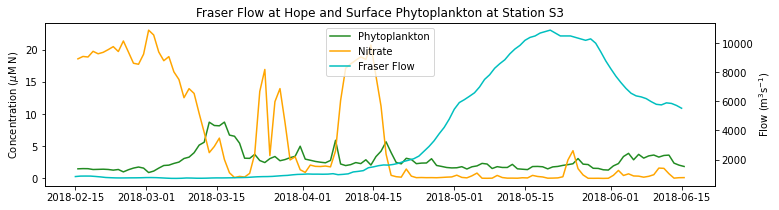

In [10]:
# plot phytoplankton on top:
fig,ax1=plt.subplots(1,1,figsize=(12,3))
p1=ax1.plot(bio_time,sphyto,
           '-',color='forestgreen',label='Phytoplankton')
p2=ax1.plot(bio_time,sno3,
           '-',color='orange',label='Nitrate')
ax1.set_ylabel('Concentration ($\mu$M N)')

# Now plot Fraser Flow
ax2=ax1.twinx()
p3=ax2.plot(riv_time,rivFlow,'c-', label='Fraser Flow')
ax2.set_ylabel('Flow (m$^3$s$^{-1}$)')
ax2.set_title('Fraser Flow at Hope and Surface Phytoplankton at Station S3')
ax1.legend(handles=[p1[0],p2[0],p3[0]],loc='upper center')

### Forcing (ops): Wind Speed

Text(0, 0.5, 'm/s')

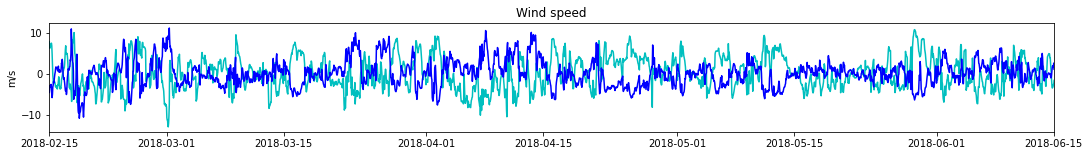

In [11]:
fig,ax=plt.subplots(1,1,figsize=(18,2))
ax.plot(twind,u_wind,'c-')
ax.plot(twind,v_wind,'b-')
ax.set_xlim(start,end)
ax.set_title('Wind speed')
ax.set_ylabel('m/s')

Text(0.5, 1.0, 'Wind Vectors in Geographic Coordinates')

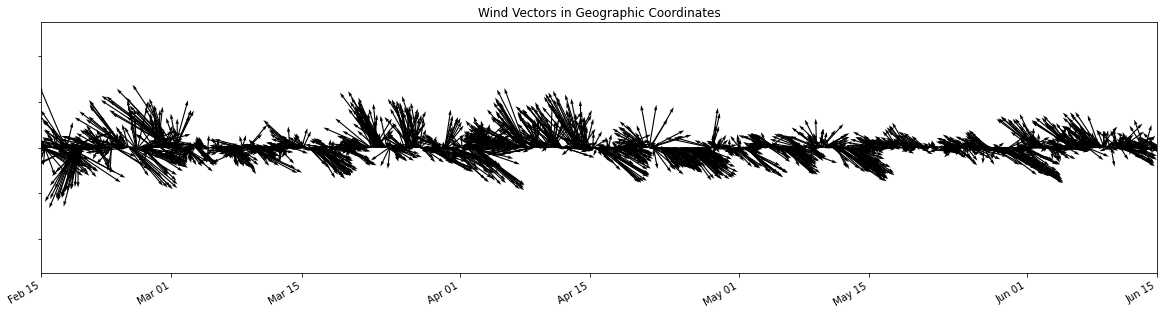

In [12]:
fig,ax=plt.subplots(1,1,figsize=(20,6))
q=ax.quiver(twind, np.zeros(len(twind)), u_wind, v_wind,scale=200, width=0.001); # change the scale
ax.set_yticklabels([]);
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(yearsFmt)
ax.set_xlim(start,end)
ax.set_title('Wind Vectors in Geographic Coordinates')
# this can probably be done better?

### Daily average wind speed

In [13]:
# calculate daily average wind speed:
ttday=twind[12::24] # start at 12th value and take every 24th
wsdaily=list()
for ii in range(0,int(len(wspeed)/24)):
    wsdaily.append(np.mean(wspeed[(ii*24):((ii+1)*24)]))
wsdaily=np.array(wsdaily) # convert to numpy array from list to be able to plot

Text(0, 0.5, 'm/s')

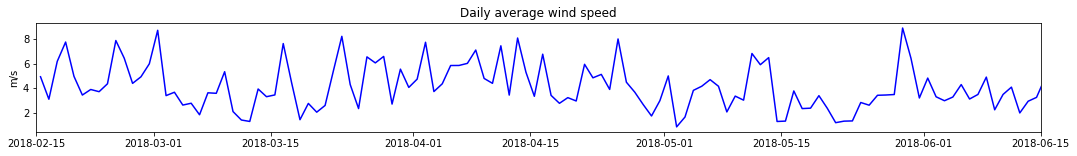

In [14]:
fig,ax=plt.subplots(1,1,figsize=(18,2))
ax.plot(ttday,wsdaily,'b-')
ax.set_xlim(start,end)
ax.set_title('Daily average wind speed')
ax.set_ylabel('m/s')

### Daily average wind speed cubed

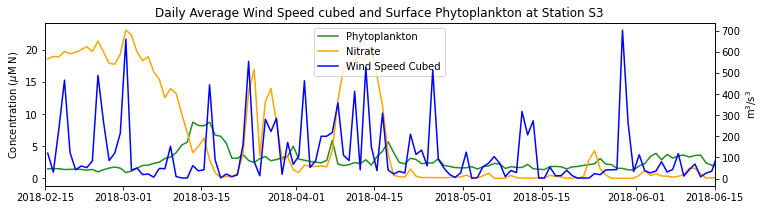

In [15]:
wscubed=wsdaily**3

# plot phytoplankton on top:
fig,ax1=plt.subplots(1,1,figsize=(12,3))
p1=ax1.plot(bio_time,sphyto,
           '-',color='forestgreen',label='Phytoplankton')
p2=ax1.plot(bio_time,sno3,
           '-',color='orange',label='Nitrate')
ax1.set_ylabel('Concentration ($\mu$M N)')

ax2=ax1.twinx()
p3=ax2.plot(ttday,wscubed,'b-',label='Wind Speed Cubed')
ax2.set_xlim(start,end)
ax2.set_title('Daily Average Wind Speed cubed and Surface Phytoplankton at Station S3')
ax2.set_ylabel('$\mathregular{m^3}$/$\mathregular{s^3}$')
ax1.legend(handles=[p1[0],p2[0],p3[0]],loc='upper center')

### Photosynthetically Available Radiation (PAR) at Surface

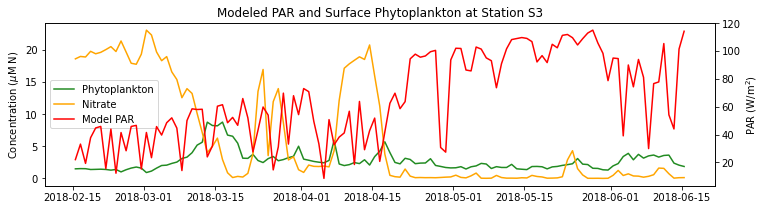

In [16]:
# plot phytoplankton on top:
fig,ax1=plt.subplots(1,1,figsize=(12,3))
p1=ax1.plot(bio_time,sphyto,
           '-',color='forestgreen',label='Phytoplankton')
p2=ax1.plot(bio_time,sno3,
           '-',color='orange',label='Nitrate')
ax1.set_ylabel('Concentration ($\mu$M N)')

ax2=ax1.twinx()
p3=ax2.plot(bio_time,spar,
           '-',color='red',label='Model PAR')
ax2.set_ylabel('PAR (W/$\mathregular{m^2}$)') # say its model PAR
ax2.set_title('Modeled PAR and Surface Phytoplankton at Station S3')
ax1.legend(handles=[p1[0],p2[0],p3[0]],loc='center left')

### Forcing: Solar radiation

Text(0, 0.5, 'W/$\\mathregular{m^2}$')

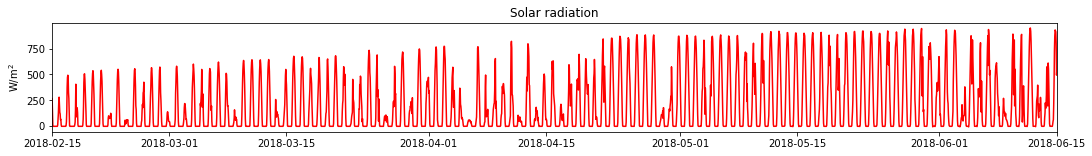

In [17]:
fig,ax=plt.subplots(1,1,figsize=(18,2))
ax.plot(twind,solar,'r-')
ax.set_xlim(start,end)
ax.set_title('Solar radiation')
ax.set_ylabel('W/$\mathregular{m^2}$')

In [18]:
# calculate daily average solar radiation:
ttday=twind[12::24] # start at 12th value and take every 24th
solardaily=list()
for ii in range(0,int(len(solar)/24)):
    solardaily.append(np.mean(solar[(ii*24):((ii+1)*24)]))
solardaily=np.array(solardaily) # convert to numpy array from list to be able to plot

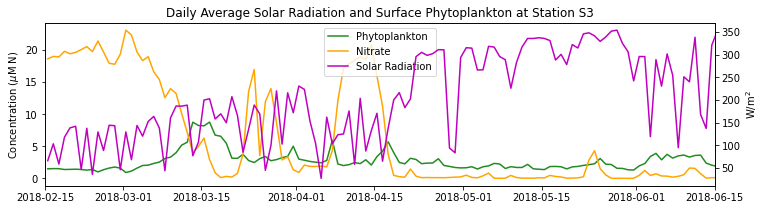

In [19]:
# plot phytoplankton on top:
fig,ax1=plt.subplots(1,1,figsize=(12,3))
p1=ax1.plot(bio_time,sphyto,
           '-',color='forestgreen',label='Phytoplankton')
p2=ax1.plot(bio_time,sno3,
           '-',color='orange',label='Nitrate')
ax1.set_ylabel('Concentration ($\mu$M N)')

ax2=ax1.twinx()
p3=ax2.plot(ttday,solardaily,'m-',label='Solar Radiation')
ax2.set_xlim(start,end)
ax2.set_title('Daily Average Solar Radiation and Surface Phytoplankton at Station S3')
ax2.set_ylabel('W/$\mathregular{m^2}$')
ax1.legend(handles=[p1[0],p2[0],p3[0]],loc='upper center')
